In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams["image.origin"] = 'lower'

In [2]:
base_dir = "/eos/home-d/dvalsecc/www/VBSPlots/DNN_archive/"

plot_configs  = ["Full2016v6s5_v2","Full2017v6s5_v2","Full2018v6s5_v2"]
#plot_configs  = ["Full2018v6s5_v2"]
#cut     = "boos_sig_mjjincl"
cut     = "boost_sig"
version = "v12"

output_dir = os.path.join(base_dir, "FullRun2", cut, "samples/" + version)

samples_dirs = [os.path.join(base_dir, p, cut, "samples/" + version) for p in plot_configs]

In [5]:
samples_dirs

['/eos/home-d/dvalsecc/www/VBSPlots/DNN_archive/Full2016v6s5_v2/boost_sig/samples/v12',
 '/eos/home-d/dvalsecc/www/VBSPlots/DNN_archive/Full2017v6s5_v2/boost_sig/samples/v12',
 '/eos/home-d/dvalsecc/www/VBSPlots/DNN_archive/Full2018v6s5_v2/boost_sig/samples/v12']

In [6]:
classes = { "VBS": 0, "Wjets":1, "top": 2, "DY": 3, "VV":3, "VBF-V":3, "VVV":3}
signal = "VBS"
sample_names = ["Wjets", "VBS", "DY", "top", "VV", "VBF-V", "VVV"]

samples = {}

for samples_dir in samples_dirs:
    for file in os.listdir(samples_dir):
        if os.path.isdir(os.path.join(samples_dir, file)): continue
        print(file)  
        if file =="index.php": continue
        sname = file.split("_part")[0]
        s = pickle.load(open(os.path.join(samples_dir, file), "rb"))
        s.rename(columns=lambda c: c.split(cut+"_")[1] if cut in c else c, inplace=True)
        s["sample_name"]= sname
        s["class"] = classes[sname]
        if sname == signal:
            s["signal"] = 1
        else: 
            s["signal"] = 0
        
        if "2016" in samples_dir:
            s["year"] = 2016
        if "2017" in samples_dir:
            s["year"] = 2017
        if "2018" in samples_dir:
            s["year"] = 2018
            
        if sname in samples:
            samples[sname] = pd.concat([samples[sname], s], ignore_index=True)
        else:
            samples[sname] = s

DY_part1.pkl
VVV_part1.pkl
Wjets_part1.pkl
Wjets_part2.pkl
top_part1.pkl
DY_part1.pkl
DY_part2.pkl
DY_part3.pkl
VBF-V_part1.pkl
VBS_part1.pkl
VVV_part1.pkl
VV_part1.pkl
Wjets_part1.pkl
Wjets_part2.pkl
Wjets_part3.pkl
top_part1.pkl
DY_part1.pkl
DY_part2.pkl
DY_part3.pkl
VBF-V_part1.pkl


/usr/local/bin/start_ipykernel.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



VBS_part1.pkl
VVV_part1.pkl
VV_part1.pkl
Wjets_part1.pkl
Wjets_part2.pkl
top_part1.pkl


In [7]:
for s, df in samples.items():
    print(f"Sample name {s:10}, nsamples: {len(df):10},   XS total: {(df.weight_).sum()*137 :15}")

Sample name DY        , nsamples:      39794,   XS total: 4091.7789245922413
Sample name VVV       , nsamples:        630,   XS total: 48.67639598207002
Sample name Wjets     , nsamples:     184961,   XS total: 24076.0866252803
Sample name top       , nsamples:      15435,   XS total: 6135.579487091349
Sample name VBF-V     , nsamples:        635,   XS total: 700.0701644591536
Sample name VBS       , nsamples:      36495,   XS total: 562.4564927073354
Sample name VV        , nsamples:      48943,   XS total: 2600.2259619833053


## Balancing

In [8]:
background = pd.concat([
                samples["top"],
                samples["DY"],
                samples["Wjets"],
                samples["VV"],
                samples["VBF-V"], 
                ], ignore_index=True)

signal = samples["VBS"]

In [9]:
'''
If random sampling will be done for the signal we need to assume that the number of signal 
events will be the same of the number of background events --> This assumption will go in the background weight. 
'''
random_sampling = False

### Normalization by bkg events

In [10]:
ratio_neve_bkgsignal= len(background) / len(signal)
print(ratio_neve_bkgsignal)

tot_ev_weighted_bkg = (background.weight_ / background.weight_.mean()).sum()
print("TOT bkg weighted events", tot_ev_weighted_bkg)

rescale_factor_sig  = (tot_ev_weighted_bkg )/ signal.weight_.sum()
print("Rescale facor for signal", rescale_factor_sig)

signal["weight_norm"] = signal.weight_ * rescale_factor_sig
background["weight_norm"] = background.weight_ / background.weight_.mean()

print("Effective sig events: ", signal.weight_norm.sum())
print("Effective bkg events: ", background.weight_norm.sum())

7.939936977668173
TOT bkg weighted events 289768.00000000006
Rescale facor for signal 70580.065328993
Effective sig events:  289768.0000000001
Effective bkg events:  289768.00000000006


In [20]:
background.weight_.sum()

1776.771994303065

In [21]:
signal.weight_.sum()

12.259606081710476

### Normalization by signal events

In [19]:
tot_ev_weighted_sig = (signal.weight_ / signal.weight_.mean()).sum()
print("TOT signal weighted events", tot_ev_weighted_sig)

if random_sampling:
    rescale_factor_bkg = (tot_ev_weighted_sig *ratio_neve_bkgsignal )/ background.weight_.sum()
else:
    rescale_factor_bkg = (tot_ev_weighted_sig )/ background.weight_.sum()
print(rescale_factor_bkg)

signal["weight_norm"] = signal.weight_ / signal.weight_.mean()
background["weight_norm"] = background.weight_ * rescale_factor_bkg

print("Effective sig events: ", signal.weight_norm.sum())
print("Effective bkg events: ", background.weight_norm.sum())

TOT signal weighted events 17509.0
73.72754218947833
Effective sig events:  17509.0
Effective bkg events:  17509.000000000004


## Save signal and bkg samples

In [11]:
import os

os.makedirs(os.path.join(output_dir, "for_training"), exist_ok=True)
pickle.dump(background, open(os.path.join(output_dir, "for_training/background_balanced.pkl"), "wb"))
pickle.dump(signal, open(os.path.join(output_dir, "for_training/signal_balanced.pkl"), "wb"))

In [30]:
signal.columns

Index(['events', 'Lepton_eta_abs', 'Lepton_eta', 'Lepton_flavour', 'Lepton_pt',
       'deltaeta_vbs', 'deta_jetpt_CR', 'PuppiMET', 'mjj_vbs', 'vbs_0_pt',
       'vbs_1_pt', 'Mtw_lep', 'whad_pt', 'deltaphi_vbs', 'mjj_vjet',
       'vjet_0_pt', 'vjet_1_pt', 'vjet_0_eta', 'vjet_1_eta', 'vbs_0_eta',
       'vbs_1_eta', 'PuppiMET_phi', 'nJets', 'N_jets_central',
       'N_jets_forward', 'Zvjets_0', 'Zvjets_1', 'Zlep', 'Asym_vbs',
       'Asym_vjet', 'Mw_lep_reco', 'w_lep_pt', 'Mww', 'R_ww', 'R_mw', 'A_ww',
       'Centr_vbs', 'Centr_ww', 'nvtx', 'weight_', 'sample_name', 'class',
       'signal', 'year', 'weight_norm'],
      dtype='object')

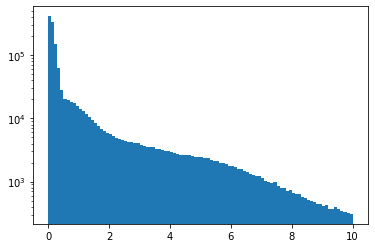

In [31]:
plt.hist(background["weight_norm"], bins=100, range=(0, 10))
plt.yscale("log")

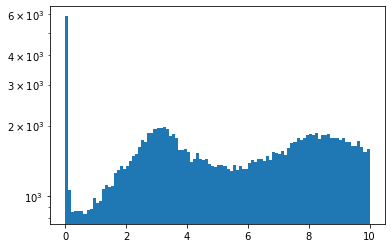

In [32]:
plt.hist(signal["weight_norm"], bins=100, range=(0, 10))
plt.yscale("log")

The total number of events will be manually balanced

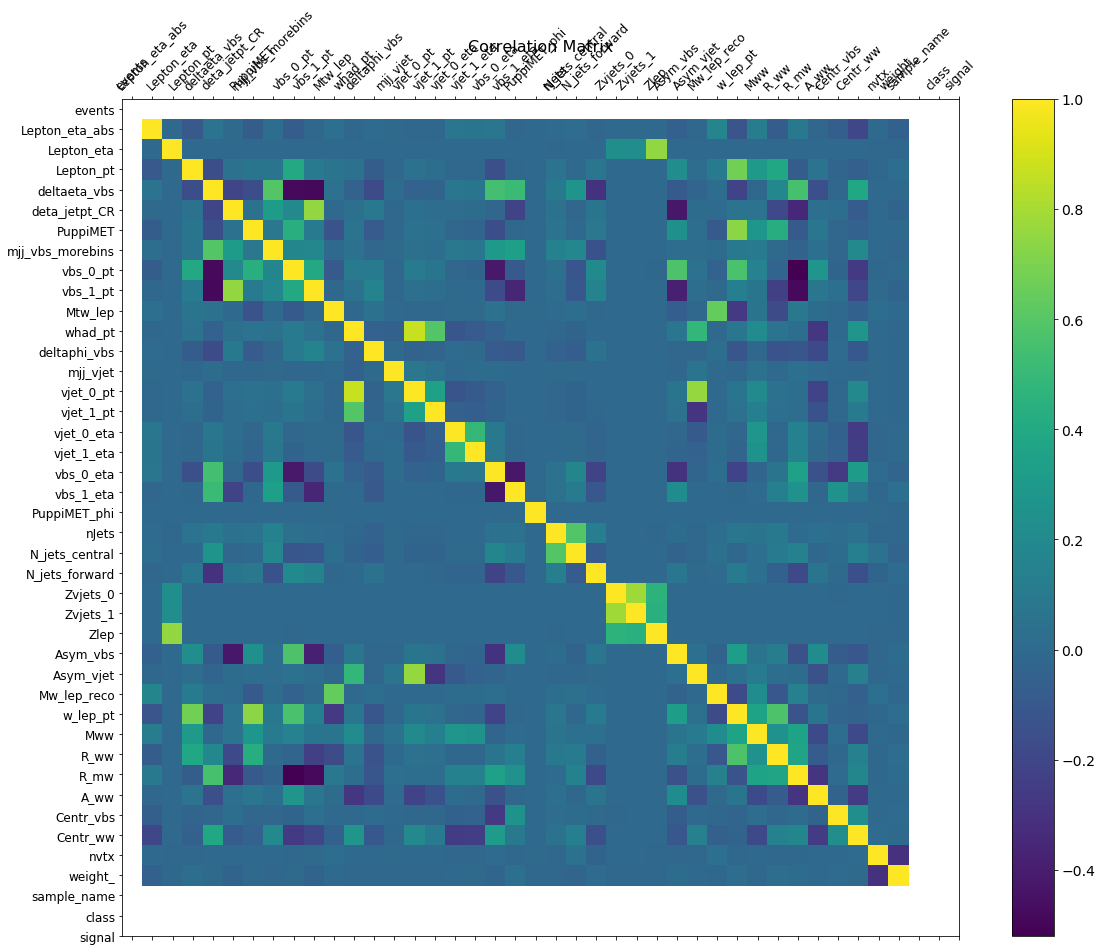

In [33]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=12, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);